In [1]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

## Problem 1

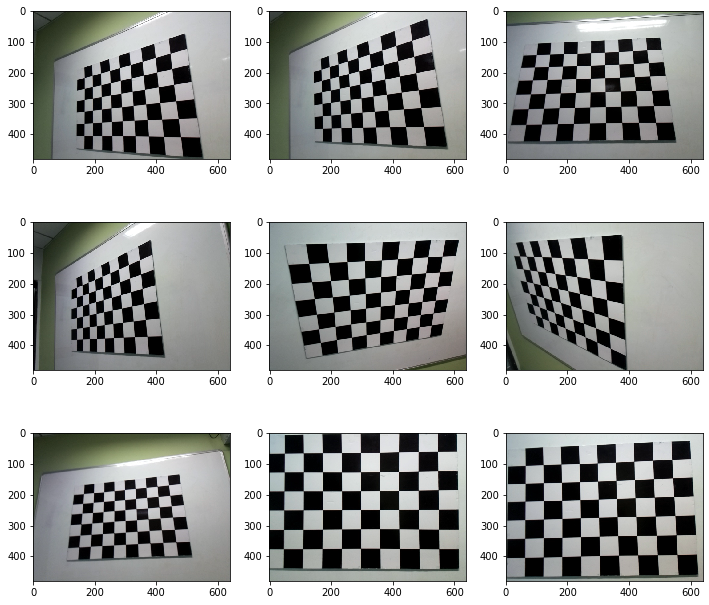

In [2]:
paths = glob.glob('images/*.jpg')
images = []
for fname in paths:
    img = cv.imread(fname)
    images.append(img)
    
samples = np.random.randint(0, 41, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 11))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[samples[i]], cmap='gray')
    
plt.show()

## Problem 2

In [3]:
def convolution_2d(img, f, stride=[1,1]):
    
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    x,y = img.shape
    f = np.flip(f)
    m,n = f.shape
    
    s_x, s_y = stride
    k_x, k_y = m//2, n//2
    pad_x, pad_y = k_x + s_x - 1, k_y + s_y  - 1
    
    img = np.pad(img, [pad_x,pad_y], 'constant')
    
    conv_img = np.zeros((x//s_x, y//s_y), dtype=np.uint8)
    
    for i,p in zip(range(pad_x, x + pad_x, s_x), range(conv_img.shape[0])):
        for j,q in zip(range(pad_y, y + pad_y, s_y), range(conv_img.shape[1])):
            w = img[i - k_x:i + k_x + 1, j - k_y:j + k_y + 1]
            conv_img[p,q] = np.dot(w.flatten(), f.flatten())

    return conv_img

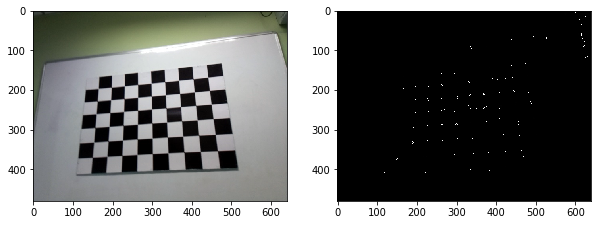

In [4]:
img = images[0]

f = (1/16) * np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])

conv_img = convolution_2d(img, f)


plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(conv_img, cmap='gray')

plt.show()

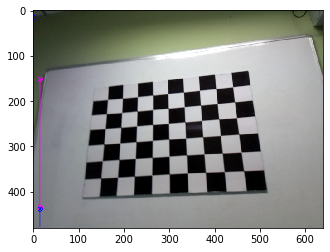

In [5]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

corners = np.asarray(np.where(conv_img >= 240), dtype=np.float32).T

corners = np.expand_dims(corners, axis=1)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)

test_img = np.copy(img)

cv.drawChessboardCorners(test_img, (7,9), corners, True)

plt.imshow(test_img)

In [95]:
corners.shape

(281775, 1, 2)

## Problem 3

In [6]:

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
corner_imgs = []
for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        corner_imgs.append(img)

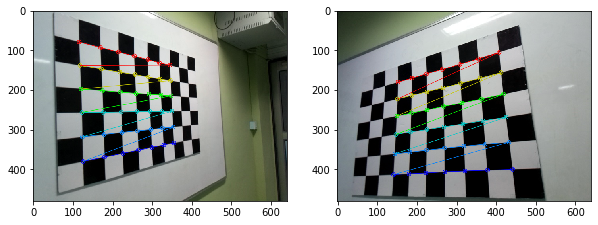

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(corner_imgs[0])

plt.subplot(122)
plt.imshow(corner_imgs[1])

plt.show()

In [8]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

###### Intrinsic Parameters

In [9]:
mtx

array([[500.16864825,   0.        , 311.7702939 ],
       [  0.        , 501.44580947, 246.01429306],
       [  0.        ,   0.        ,   1.        ]])

##### Extrinsic Parameters

In [10]:
dist, rvecs, tvecs

(array([[ 0.22548977, -0.65297254,  0.00232345, -0.00273231,  0.71740648]]),
 [array([[-1.22761698],
         [ 0.1094527 ],
         [ 2.86180041]]), array([[0.69958656],
         [0.4034327 ],
         [2.91917002]])],
 [array([[ 1.09528971],
         [ 2.20889344],
         [12.75098965]]), array([[1.95182549],
         [2.29265345],
         [7.64856742]])])

## Problem 4

In [11]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.03449103806614925


The error represents the miscalibration in the camera which in my case is 3%. This means there is not much difference between the calibrated image and the original image.

## Problem 5

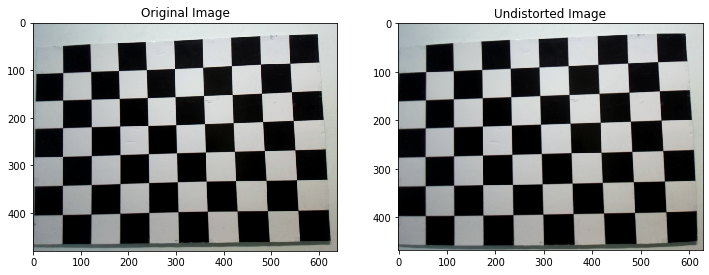

In [14]:
img = images[27]
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

dst = cv.undistort(img, mtx, dist, None, newcameramtx)

x, y, w, h = roi

dst = dst[y:y+h, x:x+w]


plt.figure(figsize=(12,10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img, cmap='gray')

plt.subplot(122)
plt.title('Undistorted Image')
plt.imshow(dst, cmap='gray')

plt.show()

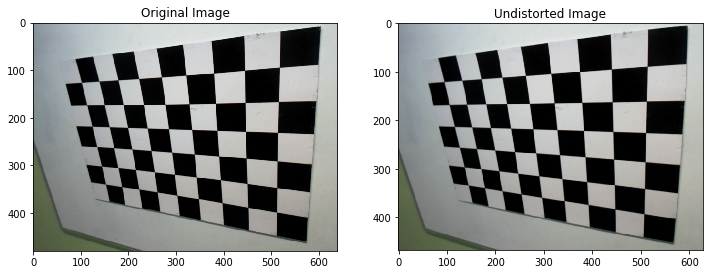

In [15]:
img = images[11]
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

dst = cv.undistort(img, mtx, dist, None, newcameramtx)

x, y, w, h = roi

dst = dst[y:y+h, x:x+w]


plt.figure(figsize=(12,10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img, cmap='gray')

plt.subplot(122)
plt.title('Undistorted Image')
plt.imshow(dst, cmap='gray')

plt.show()

There are subtle differences between the original image and the undistorted image using the new parameters. The main one is being that the new parameters caused some reduction in width.